In [5]:
!nvidia-smi

Mon Mar 18 01:27:28 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:67:00.0 Off |                  N/A |
|  0%   20C    P8    28W / 350W |   2857MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import torch
import torch.nn as nn
from torchvision import models
# from torchsummary import summary as model_summary

class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, 10, kernel_size=1)
        
    def forward(self, x):
        # print(x.shape)
        x = self.block1(x)
        # print(x.shape)
        x1 = x
        x = self.block2(x)
        # print(x.shape)
        x2 = x
        x = self.block3(x)
        # print(x.shape)
        x3 = x
        x = self.block4(x)
        # print(x.shape)
        x4 = x
        x = self.block5(x)
        # print(x.shape)
        x5 = x
        
        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        # print(score.shape, x4.shape)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

# model = FCN().to('cuda')
# model_summary(model, (1,1088,2048))

In [7]:
import torchOptics.optics as tt
import warnings 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision.transforms as trnasforms
import torch
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, random_split
import os
import glob
import math
warnings.filterwarnings('ignore') ## ignore warnings
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}

In [8]:
class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = (torch.sign(input)+1)/2
        output = output.type(torch.int32)
        output = output.type(torch.float32)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

In [9]:
def get_psnr(img1, img2, min_value=0, max_value=1):
    """
    psnr 을 계산해준다.
    이미지가 [0., 255] 이면 min_value=0, max_valu=255 로 해주고,
    이미지가 [-1,1]의 범위에 있으면 min_value=-1, max_valu=1 로 설정 해준다.
    """
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * torch.log10((PIXEL_MAX ** 2) / mse)

In [10]:
import torch.nn.functional as F
import torchvision
class Dataset512(Dataset):
    # binary hologram and simulation dataset
    # x : simulation
    # y : binary hologram
    def __init__(self, target_dir, meta, transform = None):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.resize = torchvision.transforms.Resize((1088, 2048))

    def __len__(self):
        return len(self.target_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta, gray = True)
        # print(target.shape)
        target = target.unsqueeze(0)
        target = self.resize(target)
        # sim = tt.imread(self.sim_list[idx],meta = meta, gray = True)
        # sample = {'target' : target}
        return target

In [12]:
batch_size = 1
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
train_dataset = Dataset512(target_dir = target_dir, meta = meta)
valid_dataset = Dataset512(target_dir = valid_dir, meta = meta)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [13]:
import torch
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
writer = SummaryWriter()
# model = test()
model = FCN()
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
sign_function = SignFunction.apply
epochs = 5
z = 2e-3
path = 'models/'
criterion = nn.MSELoss()
valid_image = valid_dataset[0]
for epoch in range(epochs):
    for batch_idx, target in enumerate(trainloader):
        out = model(target)
        # amp = pred[0][0]
        # pi = pred[0][1]
        # pred = amp * torch.exp(1j*pi)
        binary = sign_function(out)
        sim = tt.simulate(binary, z)
        sum_sim = torch.sum(sim, dim = 1) / 10
        # sim = torch.sum(sim)
        loss = criterion(target, sum_sim.abs()**2)
        # loss = criterion(target, pred)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        print(f'Epoch {epoch:4d}/{epochs} Batch {batch_idx + 1}/{len(trainloader)} Cost: {loss.item():.6f}')
    # print(f'------ valid : Epoch {epoch:4d}/{epochs} MSE : {valid_loss.item():.6f}')
    torch.save(model, path + 'resnet7_binary.pt')
writer.close()

Epoch    0/5 Batch 1/800 Cost: 0.035990
Epoch    0/5 Batch 2/800 Cost: 0.035274
Epoch    0/5 Batch 3/800 Cost: 0.153294
Epoch    0/5 Batch 4/800 Cost: 0.166395
Epoch    0/5 Batch 5/800 Cost: 0.170639
Epoch    0/5 Batch 6/800 Cost: 0.062480
Epoch    0/5 Batch 7/800 Cost: 0.057996
Epoch    0/5 Batch 8/800 Cost: 0.108294
Epoch    0/5 Batch 9/800 Cost: 0.152230
Epoch    0/5 Batch 10/800 Cost: 0.071454
Epoch    0/5 Batch 11/800 Cost: 0.075655
Epoch    0/5 Batch 12/800 Cost: 0.073200
Epoch    0/5 Batch 13/800 Cost: 0.041186
Epoch    0/5 Batch 14/800 Cost: 0.089431
Epoch    0/5 Batch 15/800 Cost: 0.065871
Epoch    0/5 Batch 16/800 Cost: 0.123032
Epoch    0/5 Batch 17/800 Cost: 0.127401
Epoch    0/5 Batch 18/800 Cost: 0.089558
Epoch    0/5 Batch 19/800 Cost: 0.053078
Epoch    0/5 Batch 20/800 Cost: 0.031541
Epoch    0/5 Batch 21/800 Cost: 0.081550
Epoch    0/5 Batch 22/800 Cost: 0.079682
Epoch    0/5 Batch 23/800 Cost: 0.057493
Epoch    0/5 Batch 24/800 Cost: 0.054400
Epoch    0/5 Batch 25/800

In [7]:
model = torch.load('models/resnet7_binary.pt')
model.to('cuda')

FCN(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1

In [25]:
with torch.no_grad():
    target = valid_dataset[idx]
    z = 2e-3
    idx = 0
    criterion = nn.MSELoss()
    out = model(valid_dataset[idx].unsqueeze(0))
    sign_function = SignFunction.apply
    binary = sign_function(out)
    sim = tt.simulate(binary, z)
    sum_sim = torch.sum(sim, dim = 1) / 5
    output = sum_sim.abs()**2
    # output = tt.simulate(output, 2e-3).abs()**2
    psnr = get_psnr(output, target)
    mse = criterion(output, target).item()
    print('PSNR', psnr, 'MSE', mse)

PSNR 8.381444931030273 MSE 0.14516283571720123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


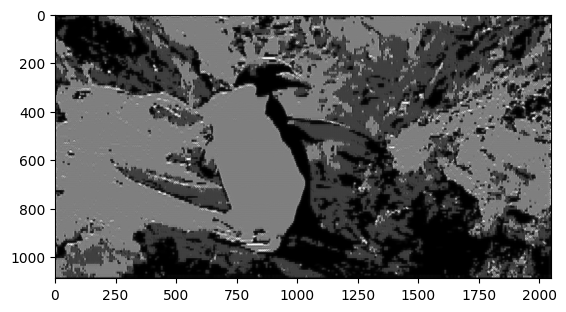

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [26]:
output

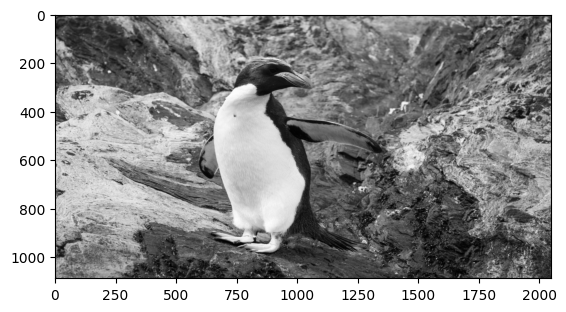

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [27]:
valid_dataset[idx]